(GLM-ordinal-regression)=
# Ordinal regression

:::{post} February, 2022
:tags: , generalized linear model, ordinal regression, pymc3.Deterministic, pymc3.Dirichlet, pymc3.HalfNormal, pymc3.Model, pymc3.Normal, pymc3.OrderedProbit
:category: beginner
:author: Benjamin T. Vincent
:::

In [1]:
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

## Introduction

### What is ordinal data?
xxx

### Why is it crucial to analyse ordinal data properly?
xxx

### The approach to modelling ordinal data

Latent variable + cutpoints

Prior on cutpoints

In [3]:
def constrainedUniform(N, dims):
    """A multivariate distribution of N elements which follow a constrained uniform distribution
    The first element will equal 0
    The final element will equal 1
    Remaining elements will be uniformly distributed between 0-1, and ordered.
    The constrainedUniform distribution will have N-2 degrees of freedom.
    """
    theta_unknown = pm.Dirichlet("theta_unknown", a=np.ones(N - 1), dims=dims)
    return pm.Deterministic(
        "theta", at.concatenate([np.zeros(1), at.extra_ops.cumsum(theta_unknown)]), dims="cutpoints"
    )

## Define some utility functions

In [4]:
def make_categorical_data(n_list, mu_list, sigma_list, cutpoints):
    bins = np.array([])
    grp_idx = np.array([])
    for i, (n, mu, sigma) in enumerate(zip(n_list, mu_list, sigma_list)):
        bins = np.append(bins, np.digitize(rng.normal(loc=mu, scale=sigma, size=n), bins=cutpoints))
        grp_idx = np.append(grp_idx, np.ones(n) * i)

    n_bins = len(cutpoints) + 1
    grp_idx = grp_idx.astype(int)
    return bins, grp_idx, n_bins

In [5]:
def plot_cutpoints(idata, cutpoint_varname="theta", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))
    cutpoints = idata.posterior[cutpoint_varname].stack(sample=["chain", "draw"])
    n_cutpoints = cutpoints.shape[0]
    sample_means = cutpoints.mean(dim="cutpoints").data
    sorted_indexes = np.argsort(sample_means)
    for i in sorted_indexes:
        ax.plot(cutpoints.data[:, i], sample_means[i] * np.ones((n_cutpoints, 1)), "ko", alpha=0.01)
    ax.set(xlabel="threshold", ylabel="mean threshold")


def plot_posterior_predictive_groups(idata, grp_idx, K, outcome_varname="y_obs"):
    """plots posterior predictive, broken down by group"""

    n_groups = len(set(grp_idx))

    fig, ax = plt.subplots(1, n_groups, figsize=(12, 3), sharey=True)

    # extract posterior predicted observations
    ppc = idata.posterior_predictive[outcome_varname].stack(samples=["chain", "draw"])

    # TODO: can we make this simpler, not having to treat a single axis differently?
    if n_groups == 1:
        # just one axis
        stats = calc_summary_stats(ppc, K)
        sns.countplot(x=bins, color="C0", ax=ax, alpha=0.5)
        # plotting posterior predictive as bars and points
        ax.plot(stats[1, :], "ko", ms=3)
        ax.set(xlabel="bin")
        for i in np.arange(K):
            ax.plot([i, i], [stats[0, i], stats[2, i]], "k")

    else:
        # multiple groups, multiple axes
        for group in set(grp_idx):
            # split observations by group membership
            _ppc = ppc[grp_idx == group, :]

            stats = calc_summary_stats(_ppc, K)

            # plot observed bin counts as bar plots
            sns.countplot(x=bins[grp_idx == group], color="C0", ax=ax[group], alpha=0.5)

            # plotting posterior predictive as bars and points
            ax[group].plot(stats[1, :], "ko", ms=3)
            ax[group].set(xlabel="bin", title=f"{group=}")
            for i in np.arange(K):
                ax[group].plot([i, i], [stats[0, i], stats[2, i]], "k")


def calc_summary_stats(ppc, K):
    # fill a matrix size (K x samples) of bin counts
    n_samples = ppc.shape[1]
    counts = np.zeros((K, n_samples))
    # iterate over posterior predictions, calculating bin counts for each sample
    for i in np.arange(n_samples):
        counts[:, i] = np.bincount(ppc[:, i], minlength=K)
    # calculate percentiles for each bin
    stats = np.percentile(counts, [2.5, 50, 97.5], axis=1)
    return stats

# ORDINAL REGRESSION MODEL

The simplest we could do is:

```python
COORDS = {"cutpoints": np.arange(K-1), 
          "free_cutpoints": np.arange(K)[1:-1], 
          "obs": np.arange(len(bins))}

with pm.Model(coords=COORDS) as model:
    # priors
    cutpoints = constrainedUniform(K-1, dims="free_cutpoints")
    mu = pm.Normal("mu", mu=K/2, sigma=K)
    sigma = pm.HalfNormal("sigma", 1)
    # likelihood
    pm.OrderedProbit("y_obs", cutpoints=cutpoints, eta=mu, sigma=sigma, observed=bins)
```

But to we will embelish this _slightly_ by assuming there is a categorical predictor. We can of course set this as having only 1 level, and it is equivalent to the above model.

In [6]:
def ordinal_regression(bins, grp_idx, K):
    """A function which returns a PyMC model"""

    COORDS = {
        "cutpoints": np.arange(K - 1),
        "free_cutpoints": np.arange(K)[1:-1],
        "obs": np.arange(len(bins)),
        "groups": np.unique(grp_idx),
    }

    with pm.Model(coords=COORDS) as model:
        # priors
        cutpoints = constrainedUniform(K - 1, dims="free_cutpoints")
        mu = pm.Normal("mu", mu=K / 2, sigma=K, dims="groups")
        sigma = pm.HalfNormal("sigma", 1, dims="groups")
        # likelihood
        pm.OrderedProbit(
            "y_obs", cutpoints=cutpoints, eta=mu[grp_idx], sigma=sigma[grp_idx], observed=bins
        )

    return model

## Model 1 - single group model
First we will explore a single group ordinal model. Another way of saying this is that we will explore a control (or intercept-only) model. Normally we will have multiple predictor variables, but a null model like this can in fact be useful. For example, we can test how well our data can actually be explained by a model assuming there is only one group.

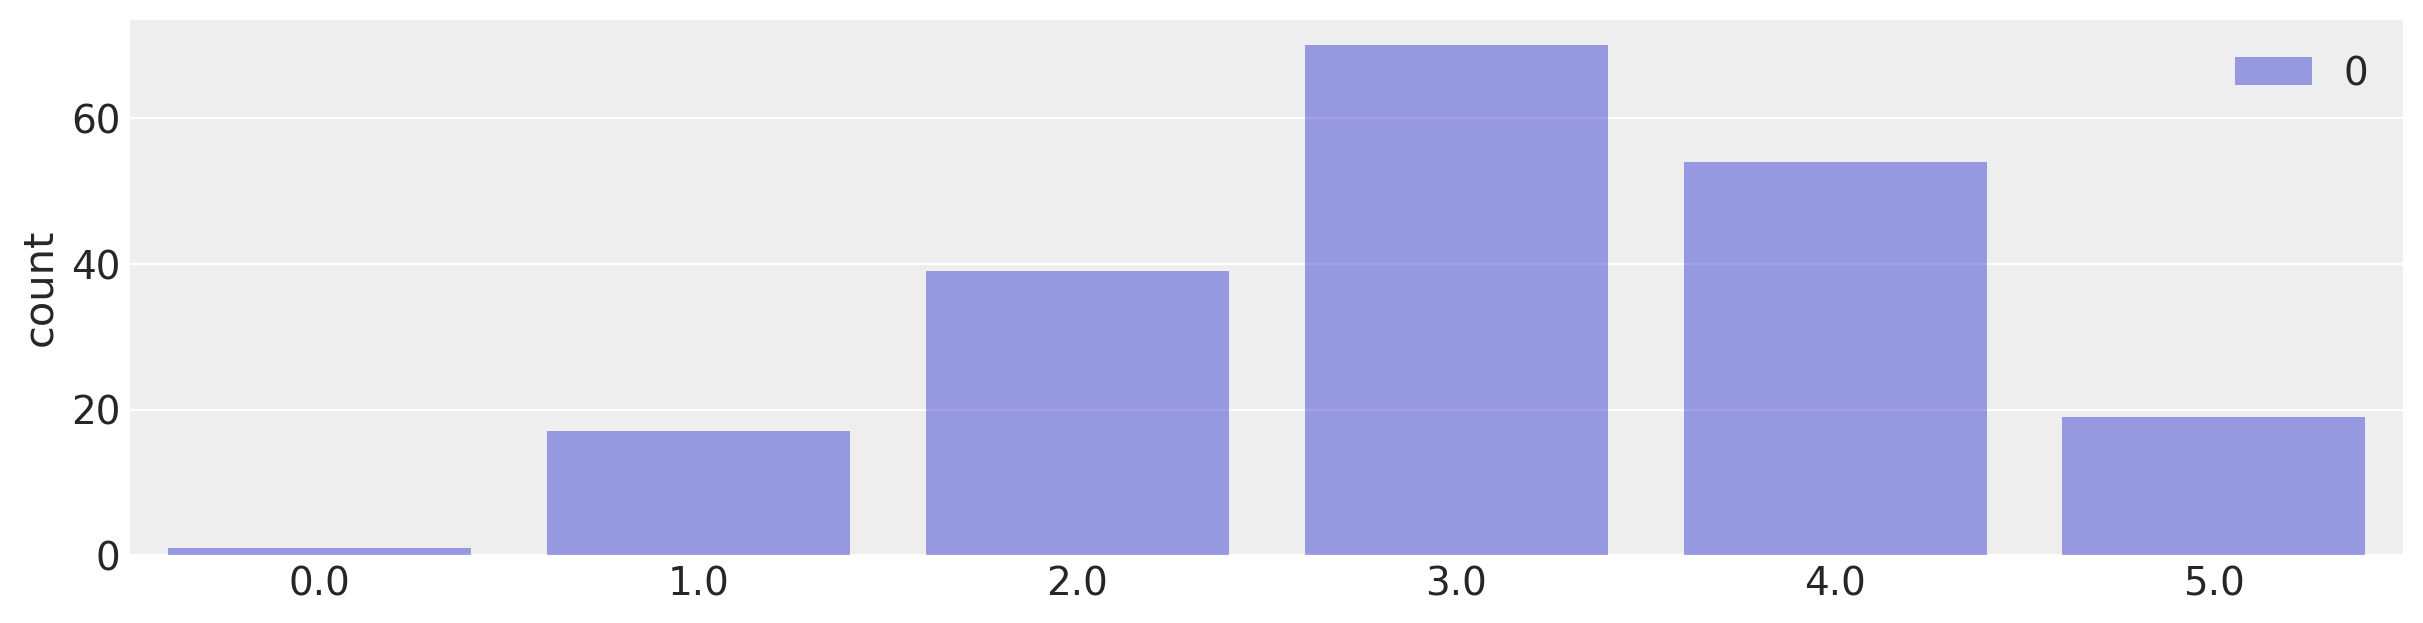

In [7]:
bins, grp_idx, K = make_categorical_data([200], [0.5], [1], cutpoints=[-2.0, -1.0, 0.0, 1.0, 2.0])

fig, ax = plt.subplots(figsize=(12, 3))
sns.countplot(x=bins, hue=grp_idx, alpha=0.5, ax=ax);

In [8]:
model = ordinal_regression(bins, grp_idx, K)

with model:
    idata = pm.sample(init="adapt_diag")
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_unknown, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
The number of effective samples is smaller than 25% for some parameters.


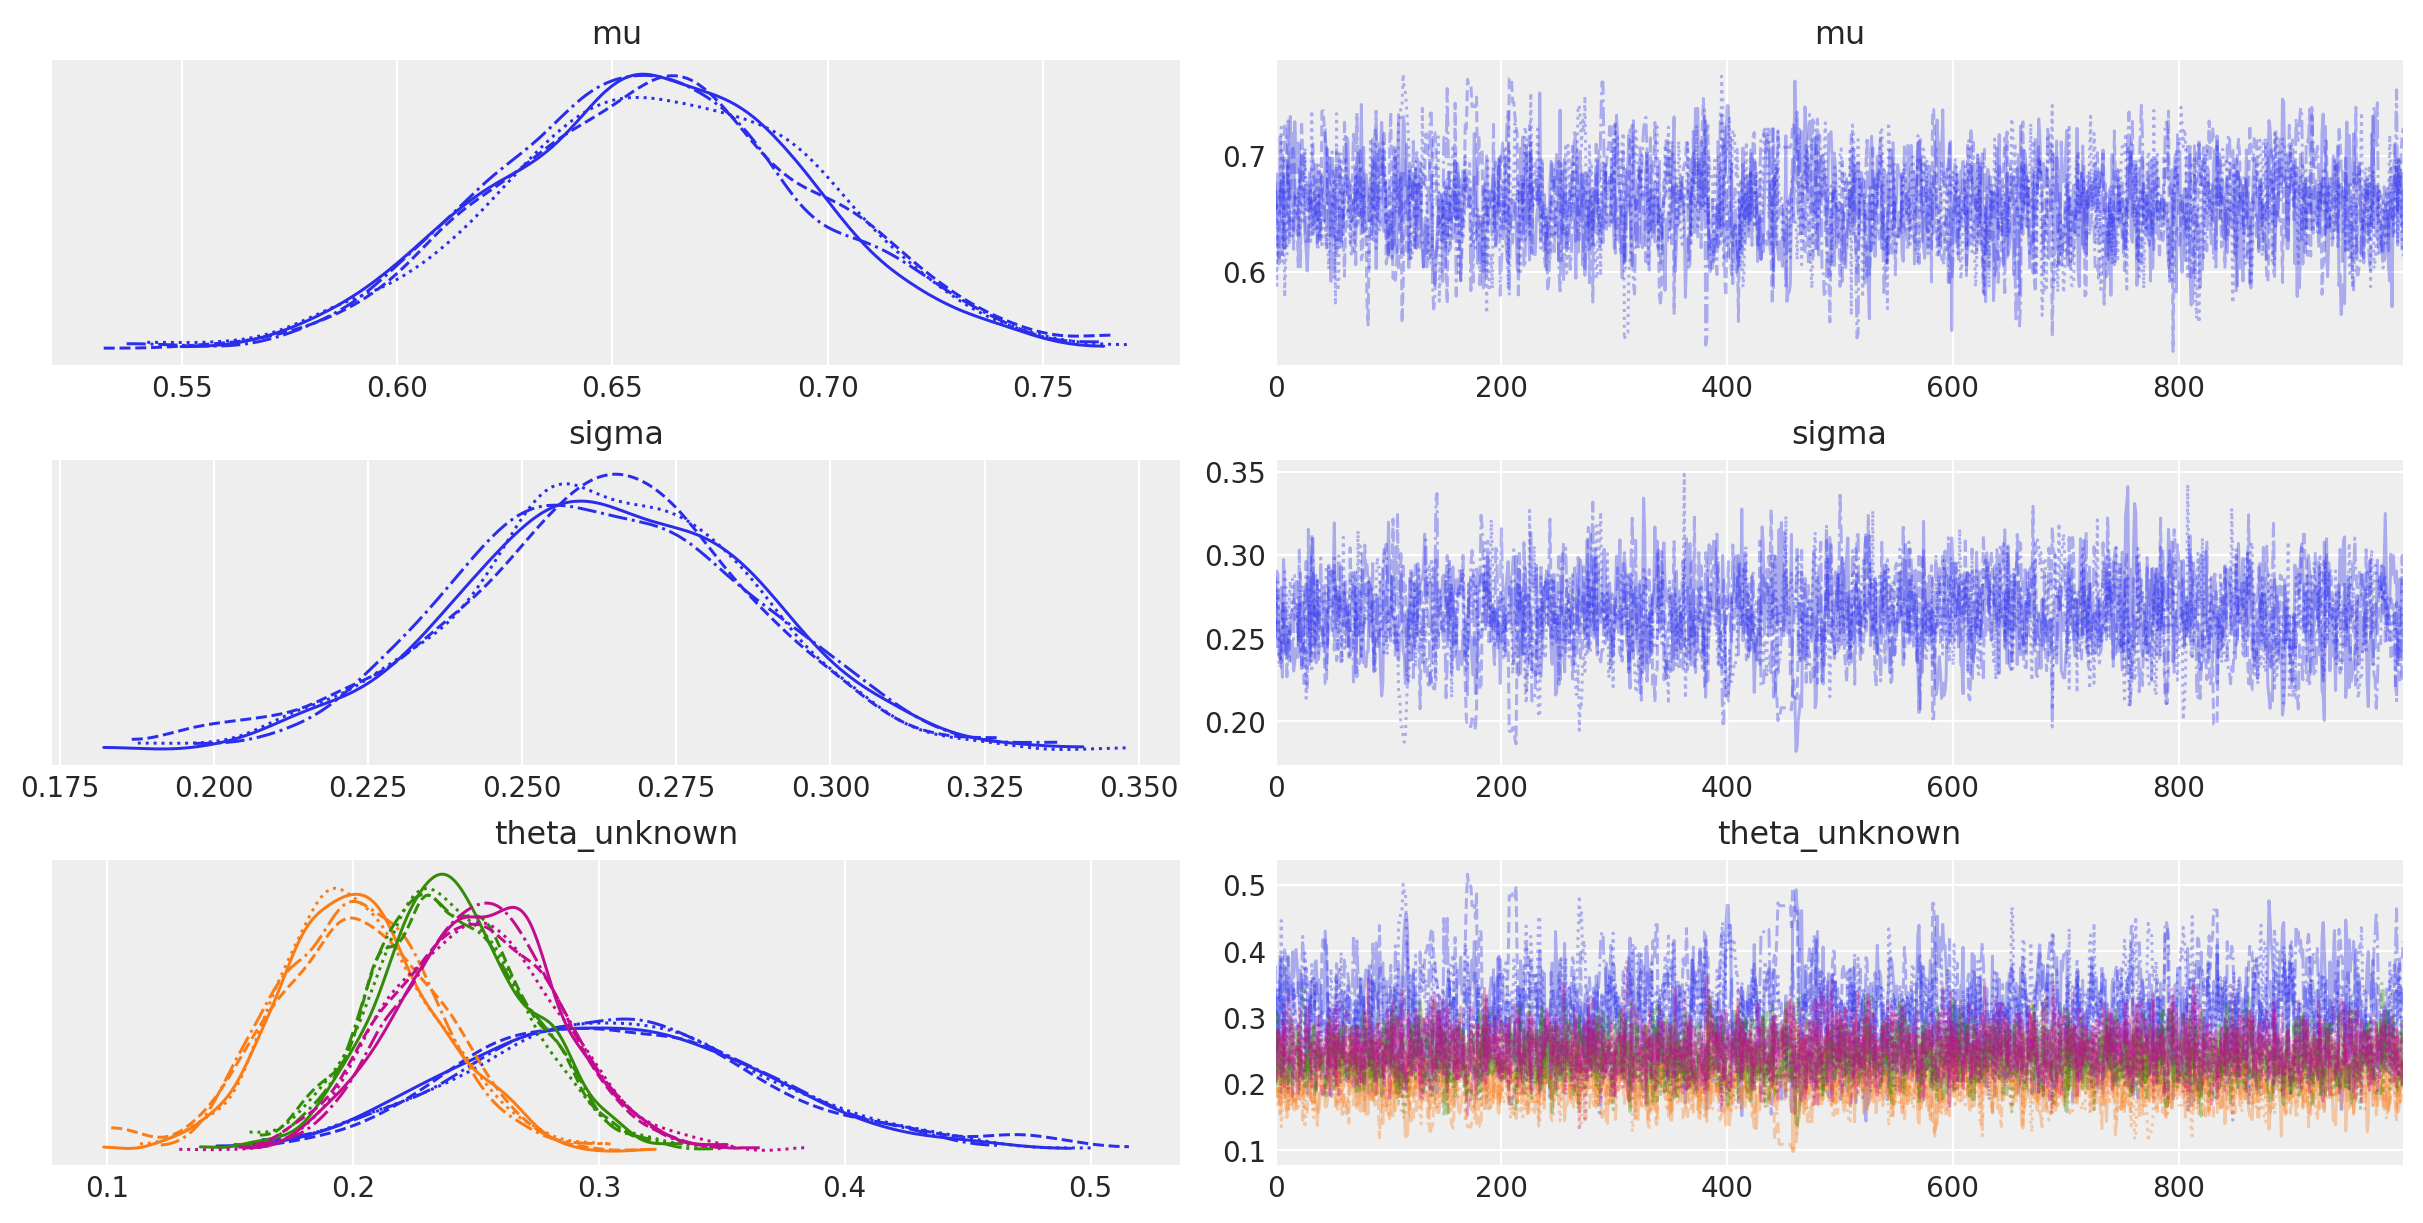

In [9]:
az.plot_trace(idata, var_names=["mu", "sigma", "theta_unknown"]);

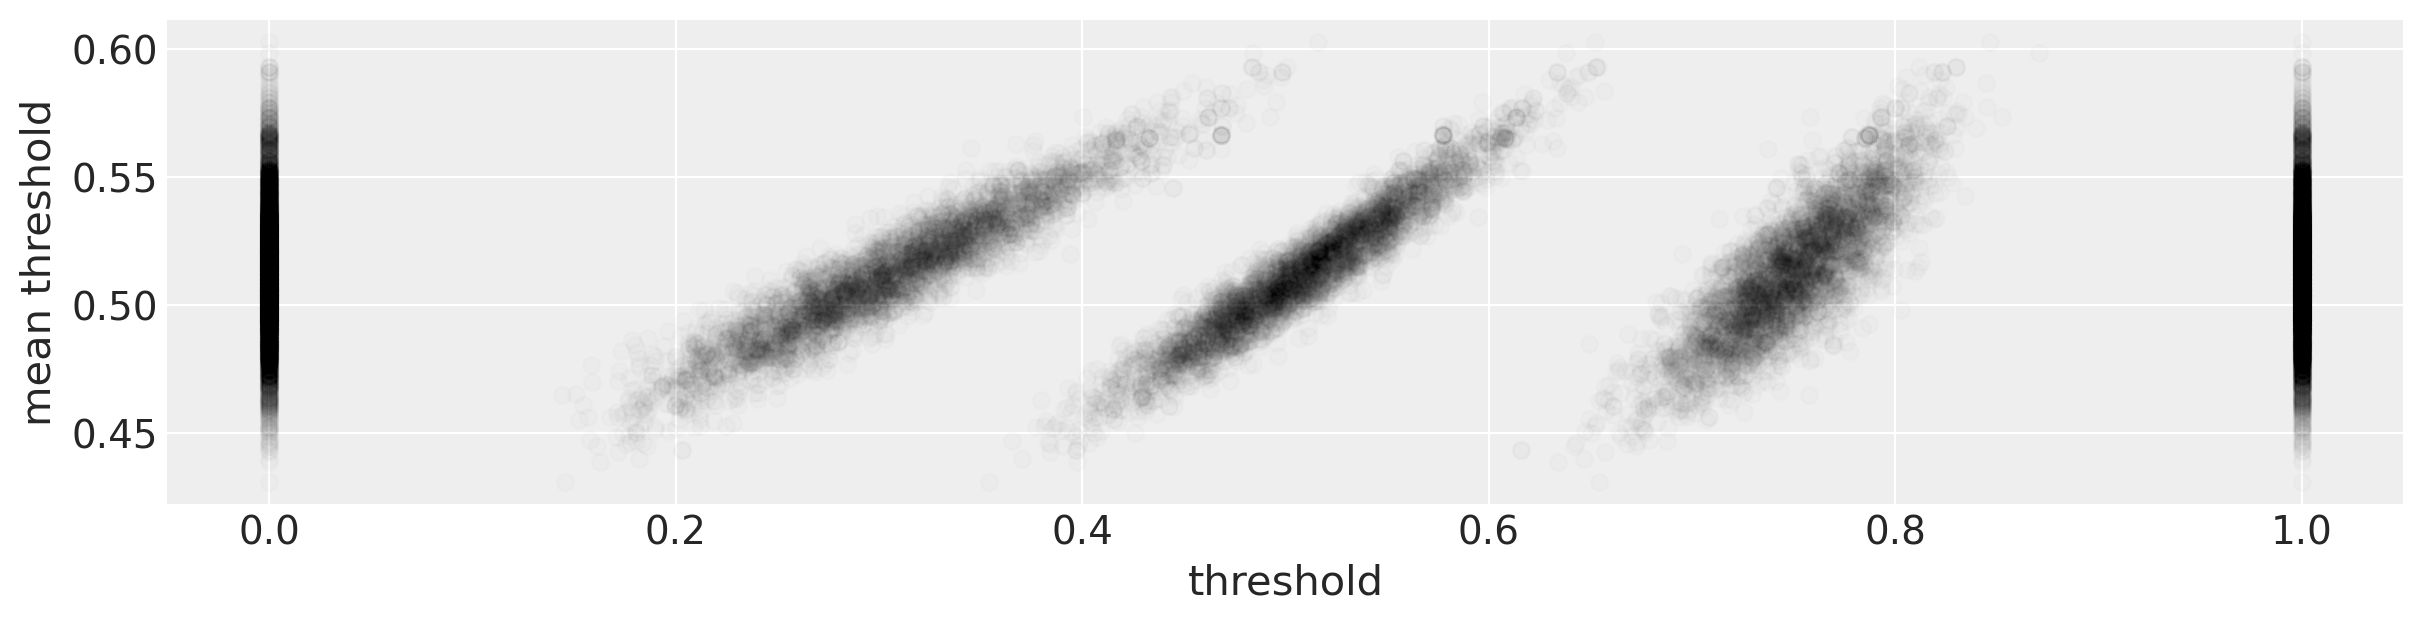

In [10]:
plot_cutpoints(idata)

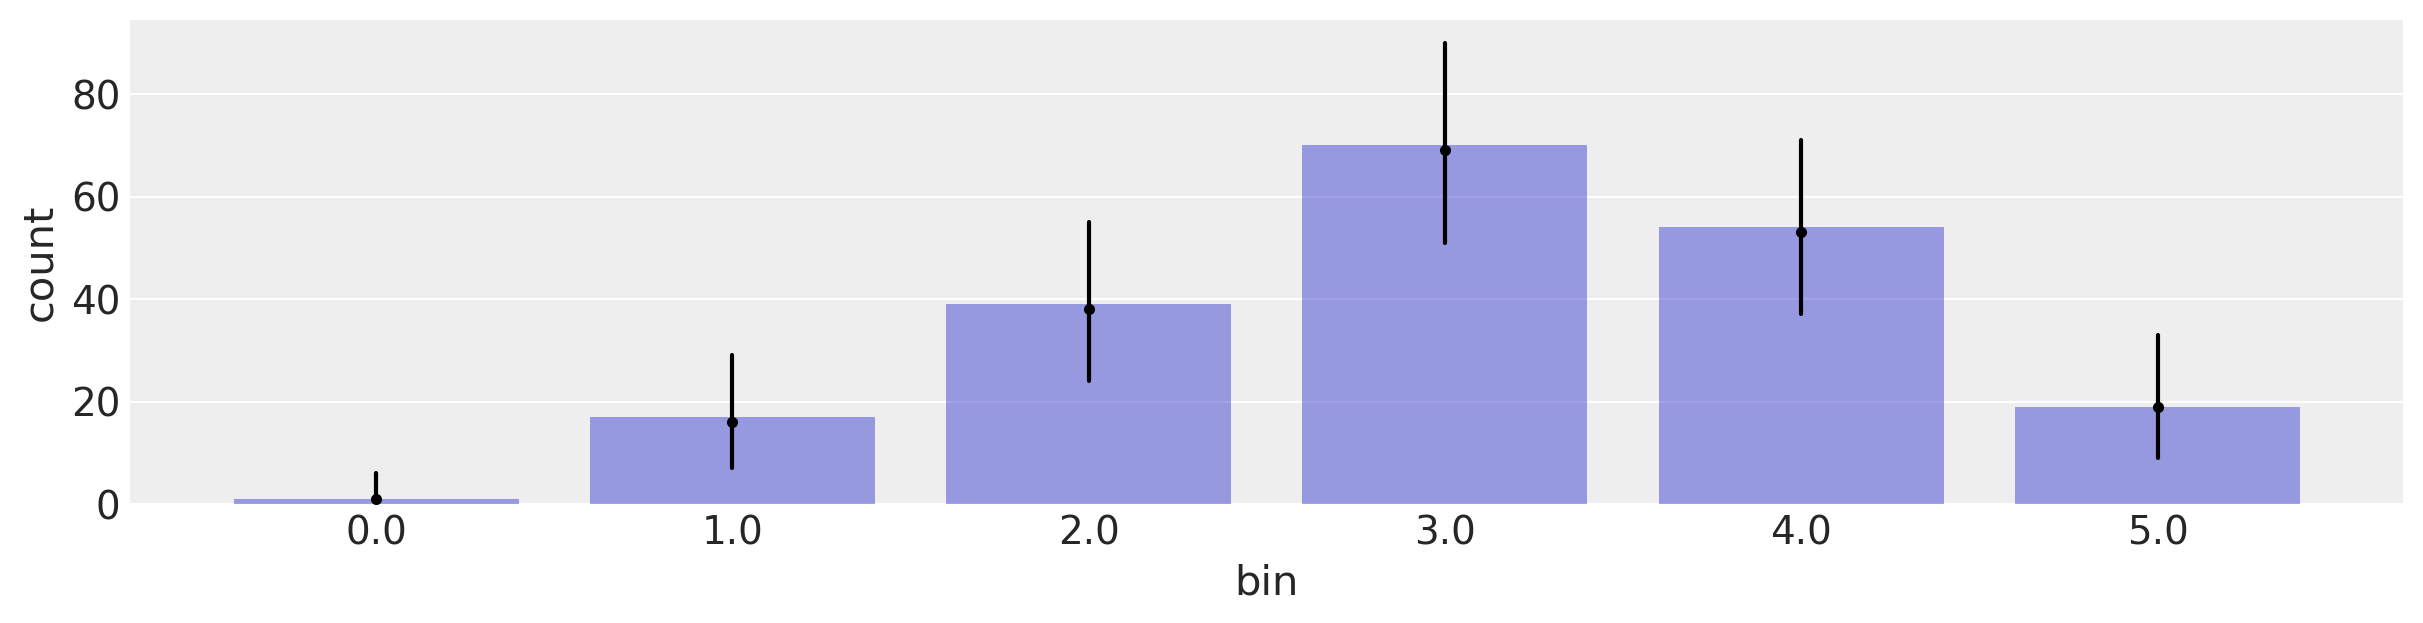

In [11]:
plot_posterior_predictive_groups(idata, grp_idx, K)

## Model 2 - Categorical predictors

### First we look at a 2-level categorical predictor

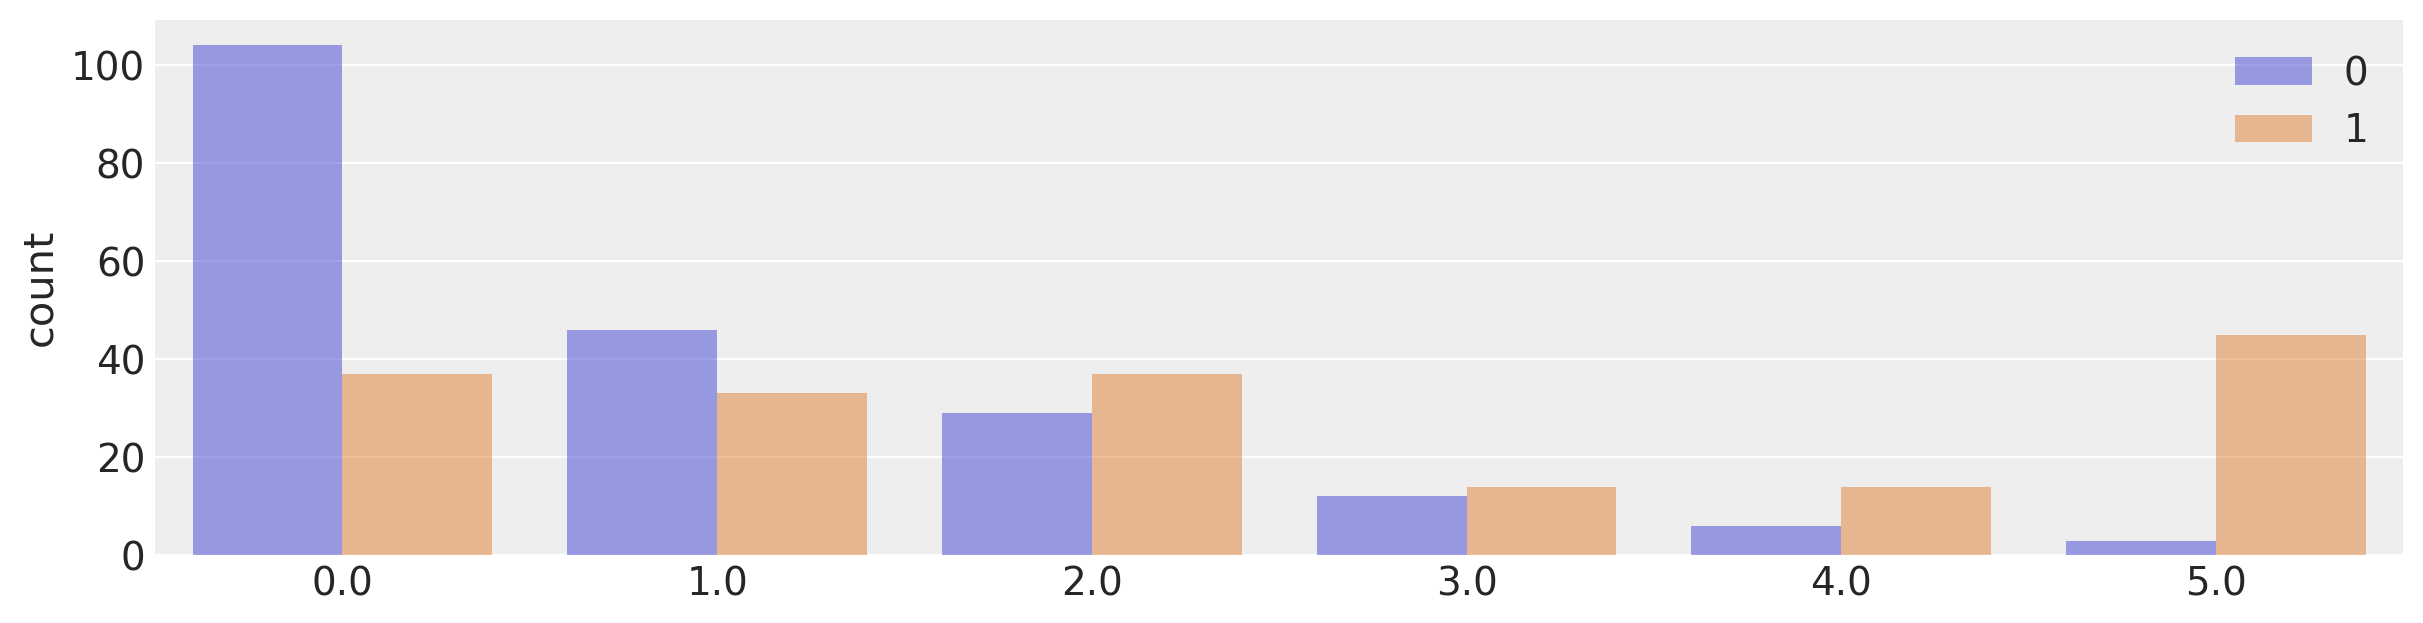

In [12]:
bins, grp_idx, K = make_categorical_data(
    [200, 180], [-2, -0.5], [1.5, 2], cutpoints=[-2.0, -1.0, 0.0, 0.5, 1.0]
)

fig, ax = plt.subplots(figsize=(12, 3))
sns.countplot(x=bins, hue=grp_idx, alpha=0.5, ax=ax);

In [13]:
model = ordinal_regression(bins, grp_idx, K)
# pm.model_graph.model_to_graphviz(model)

with model:
    idata = pm.sample(init="adapt_diag")
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_unknown, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


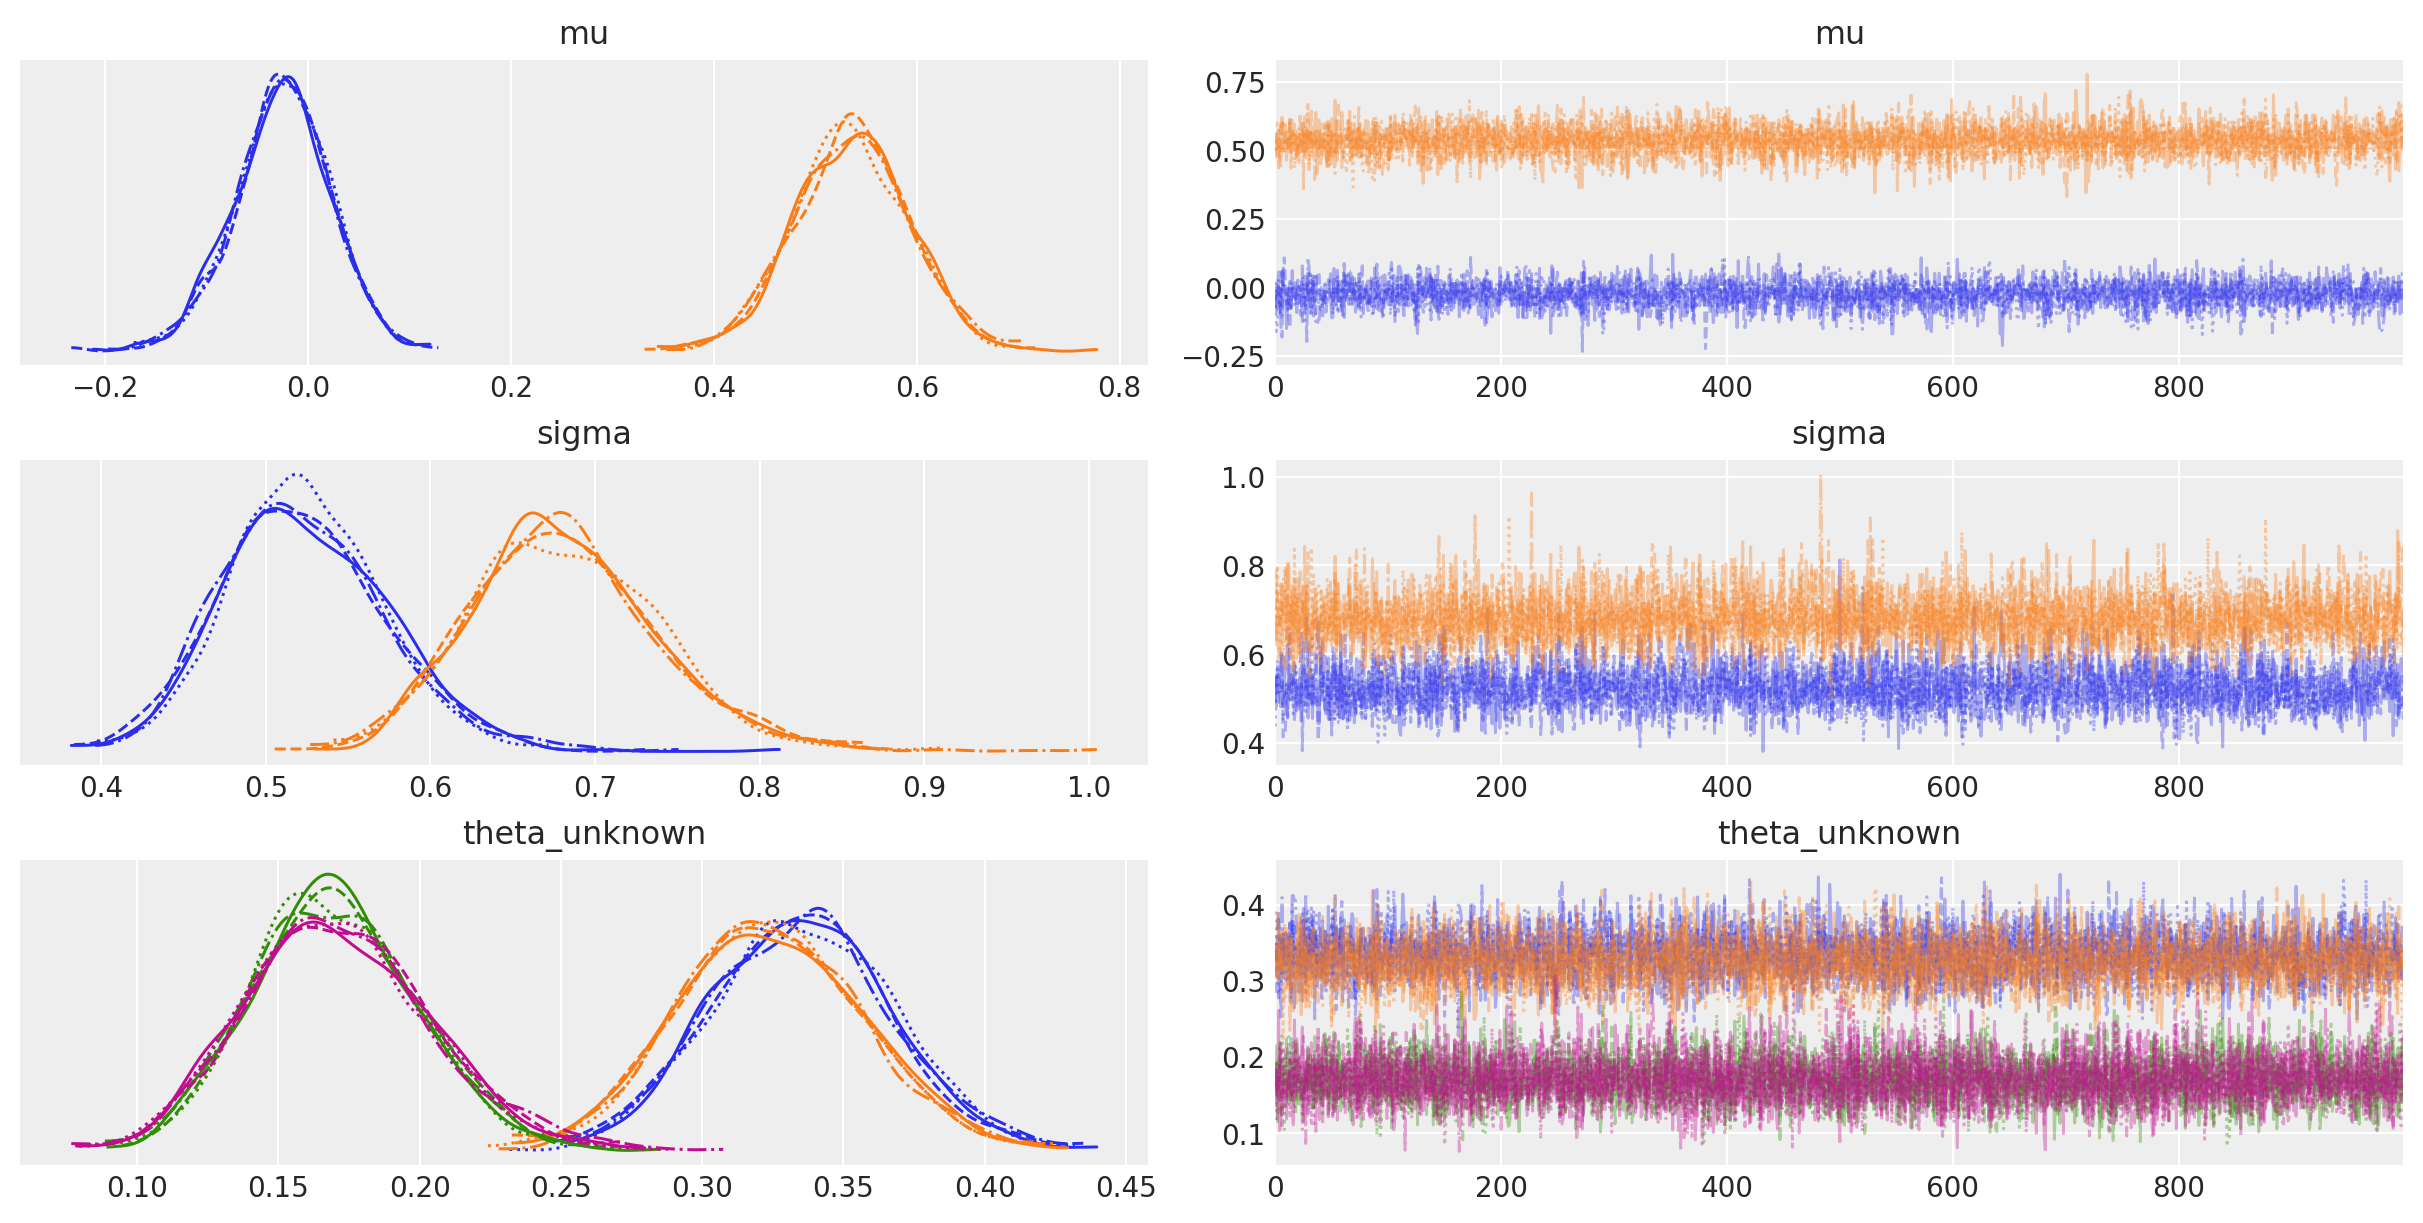

In [14]:
az.plot_trace(idata, var_names=["mu", "sigma", "theta_unknown"]);

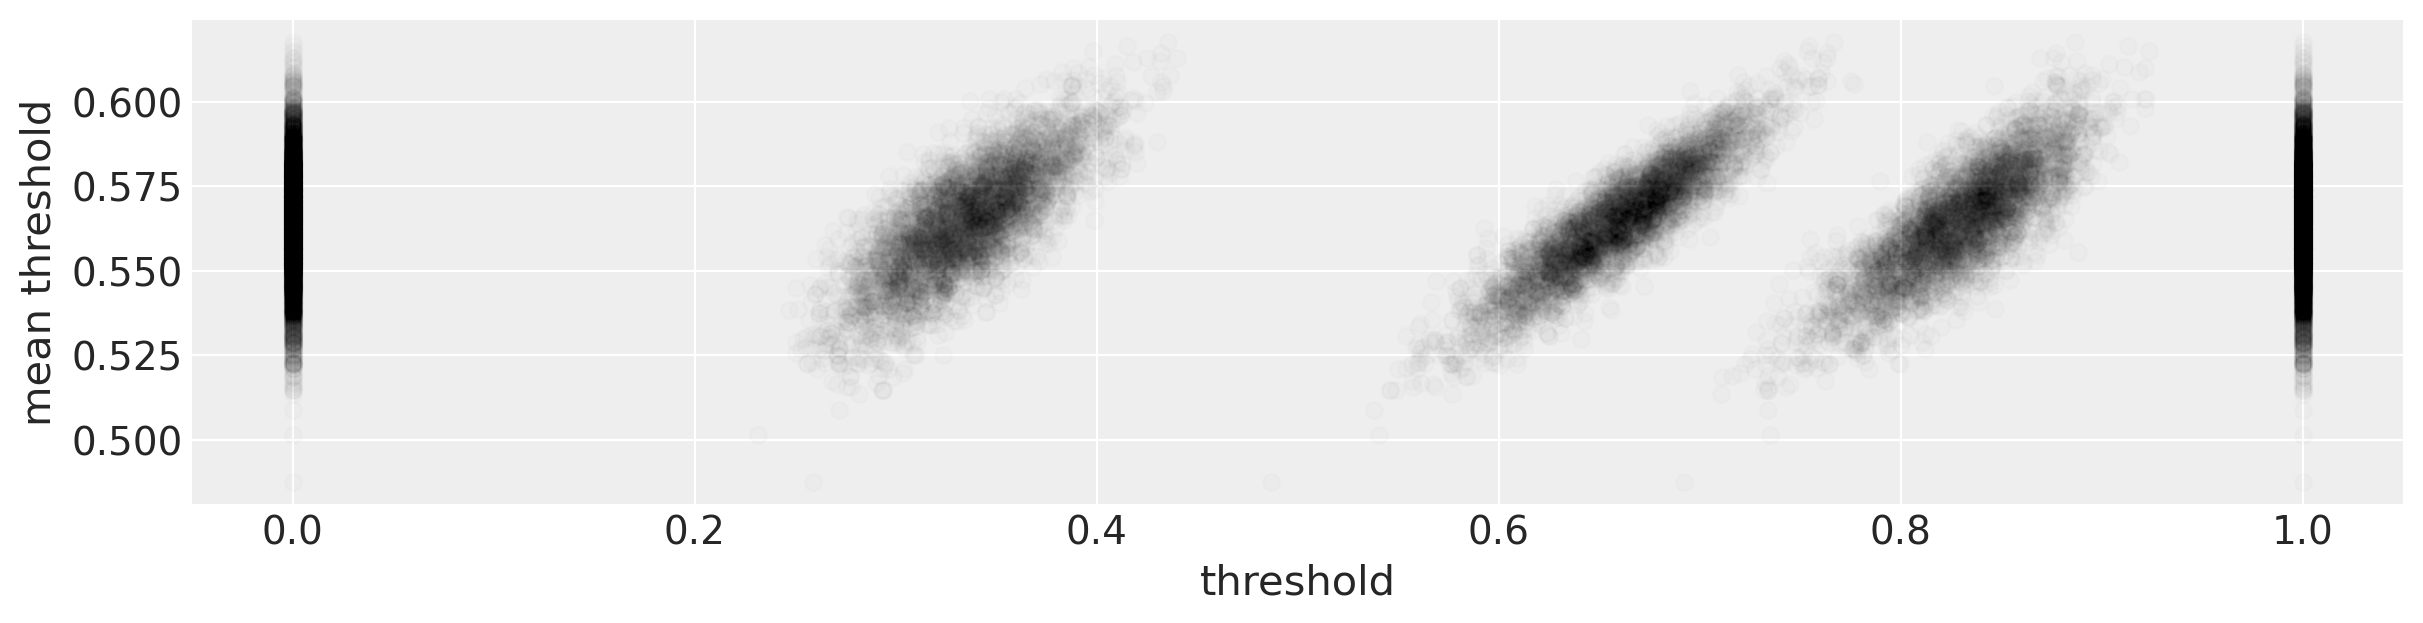

In [15]:
plot_cutpoints(idata)

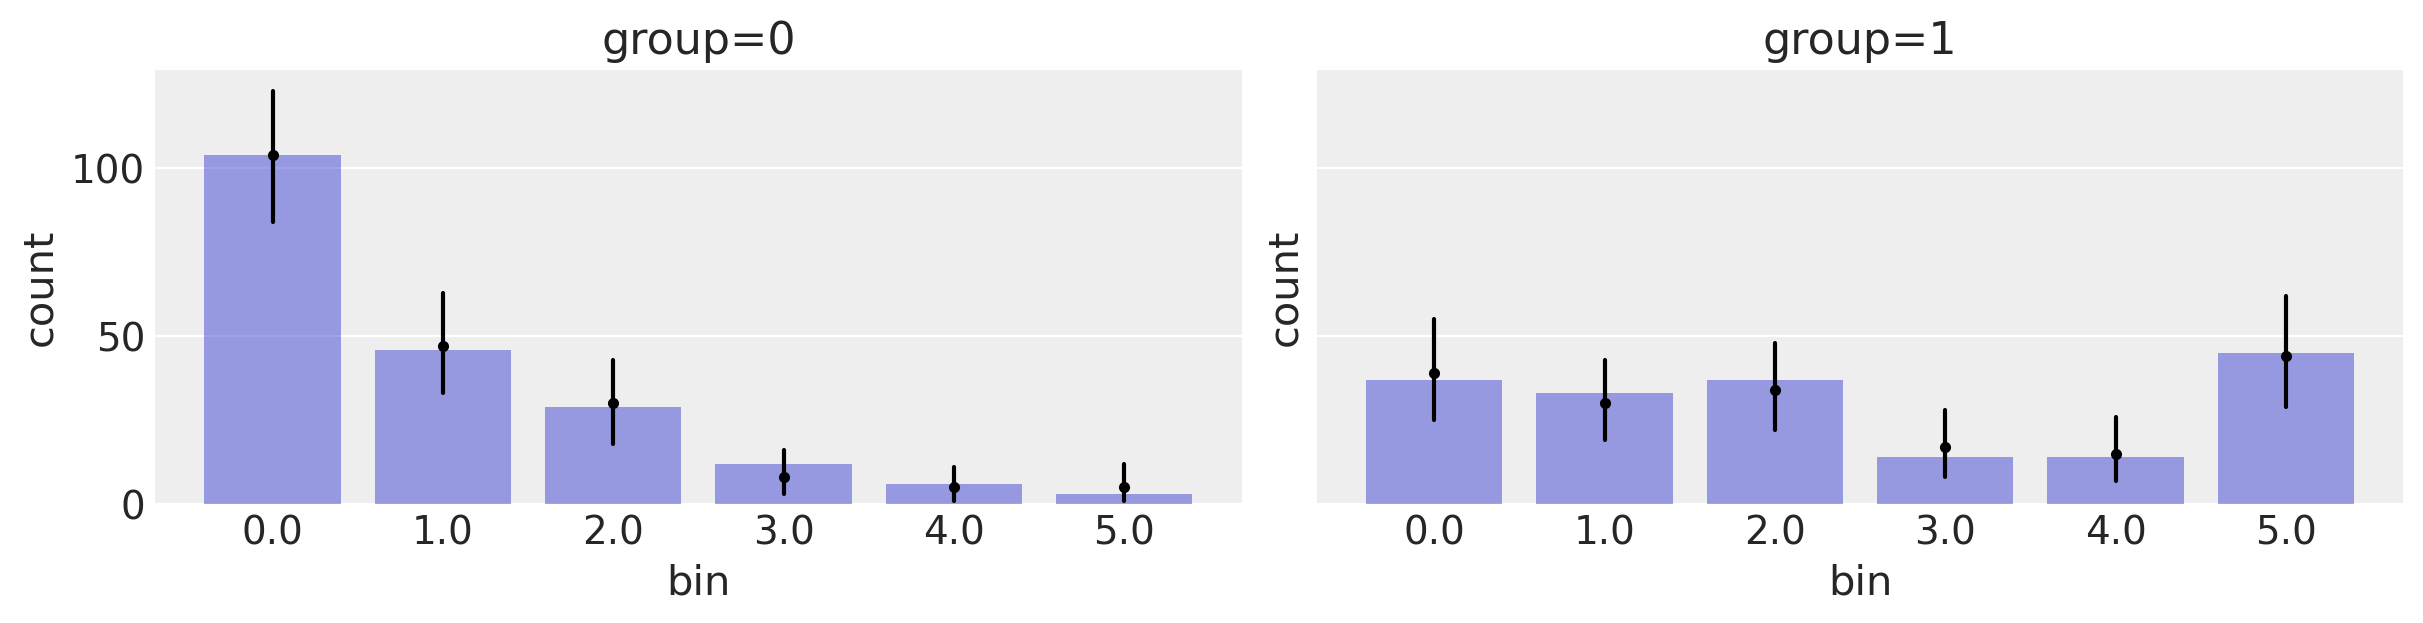

In [16]:
plot_posterior_predictive_groups(idata, grp_idx, K)

### Now we look at a 4-level categorical predictor

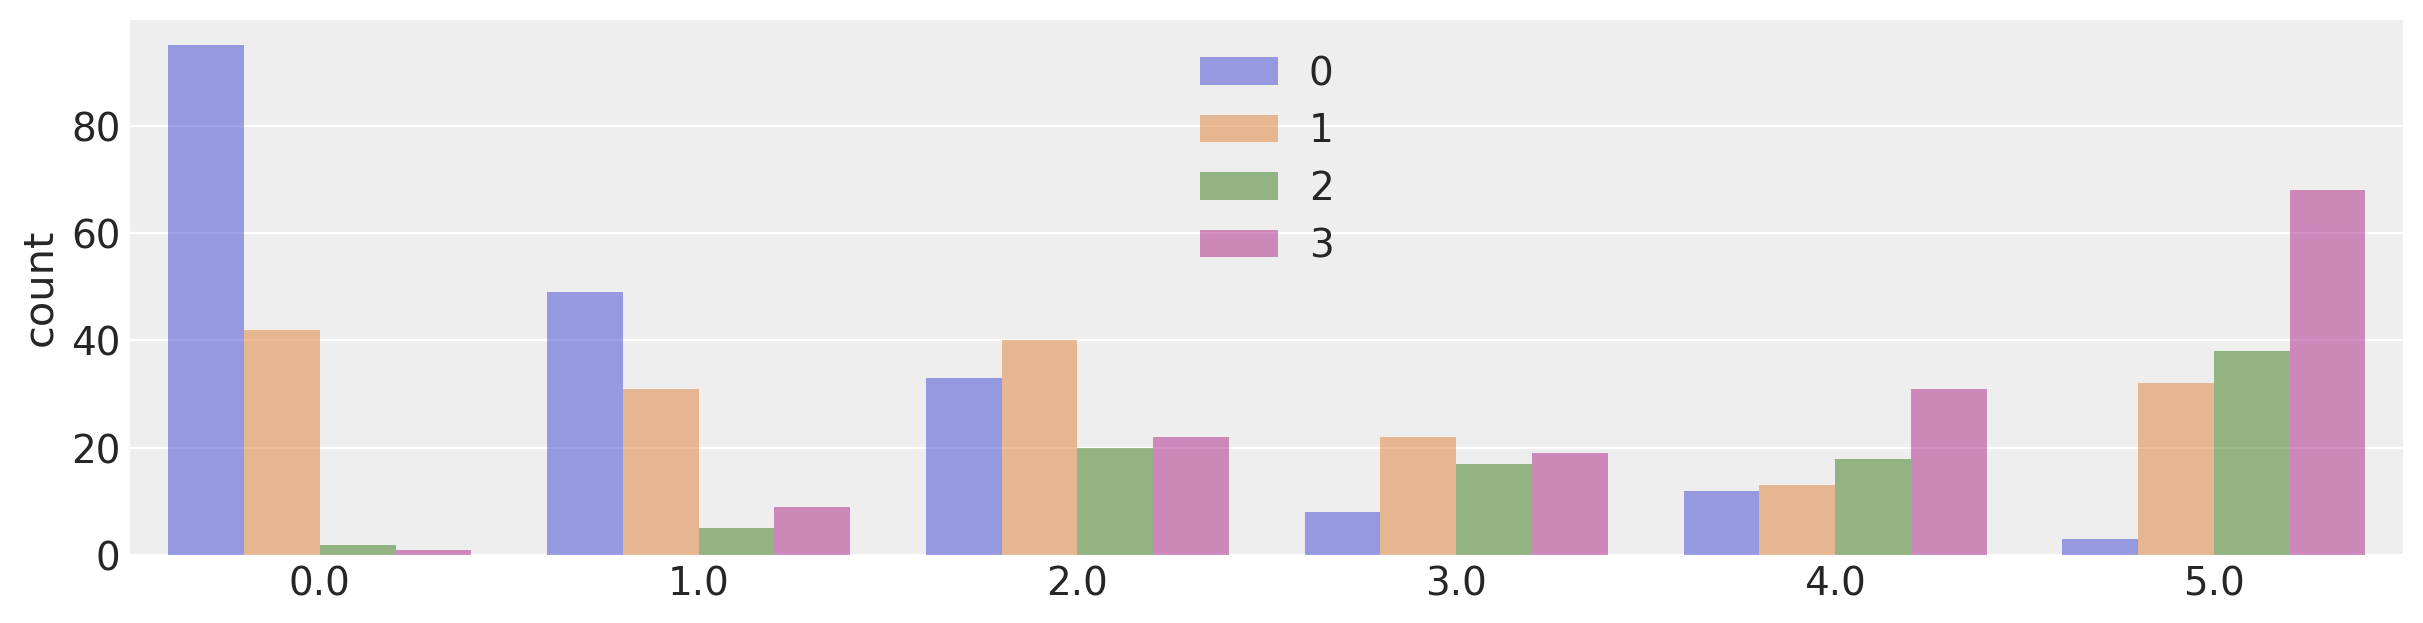

In [17]:
bins, grp_idx, K = make_categorical_data(
    [200, 180, 100, 150],
    [-2, -0.5, 0.6, 0.8],
    [1.5, 2, 1.3, 1.5],
    cutpoints=[-2.0, -1.0, 0.0, 0.5, 1.0],
)

fig, ax = plt.subplots(figsize=(12, 3))
sns.countplot(x=bins, hue=grp_idx, alpha=0.5, ax=ax);

In [18]:
model = ordinal_regression(bins, grp_idx, K)
# pm.model_graph.model_to_graphviz(model)

with model:
    idata = pm.sample(init="adapt_diag")
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_unknown, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


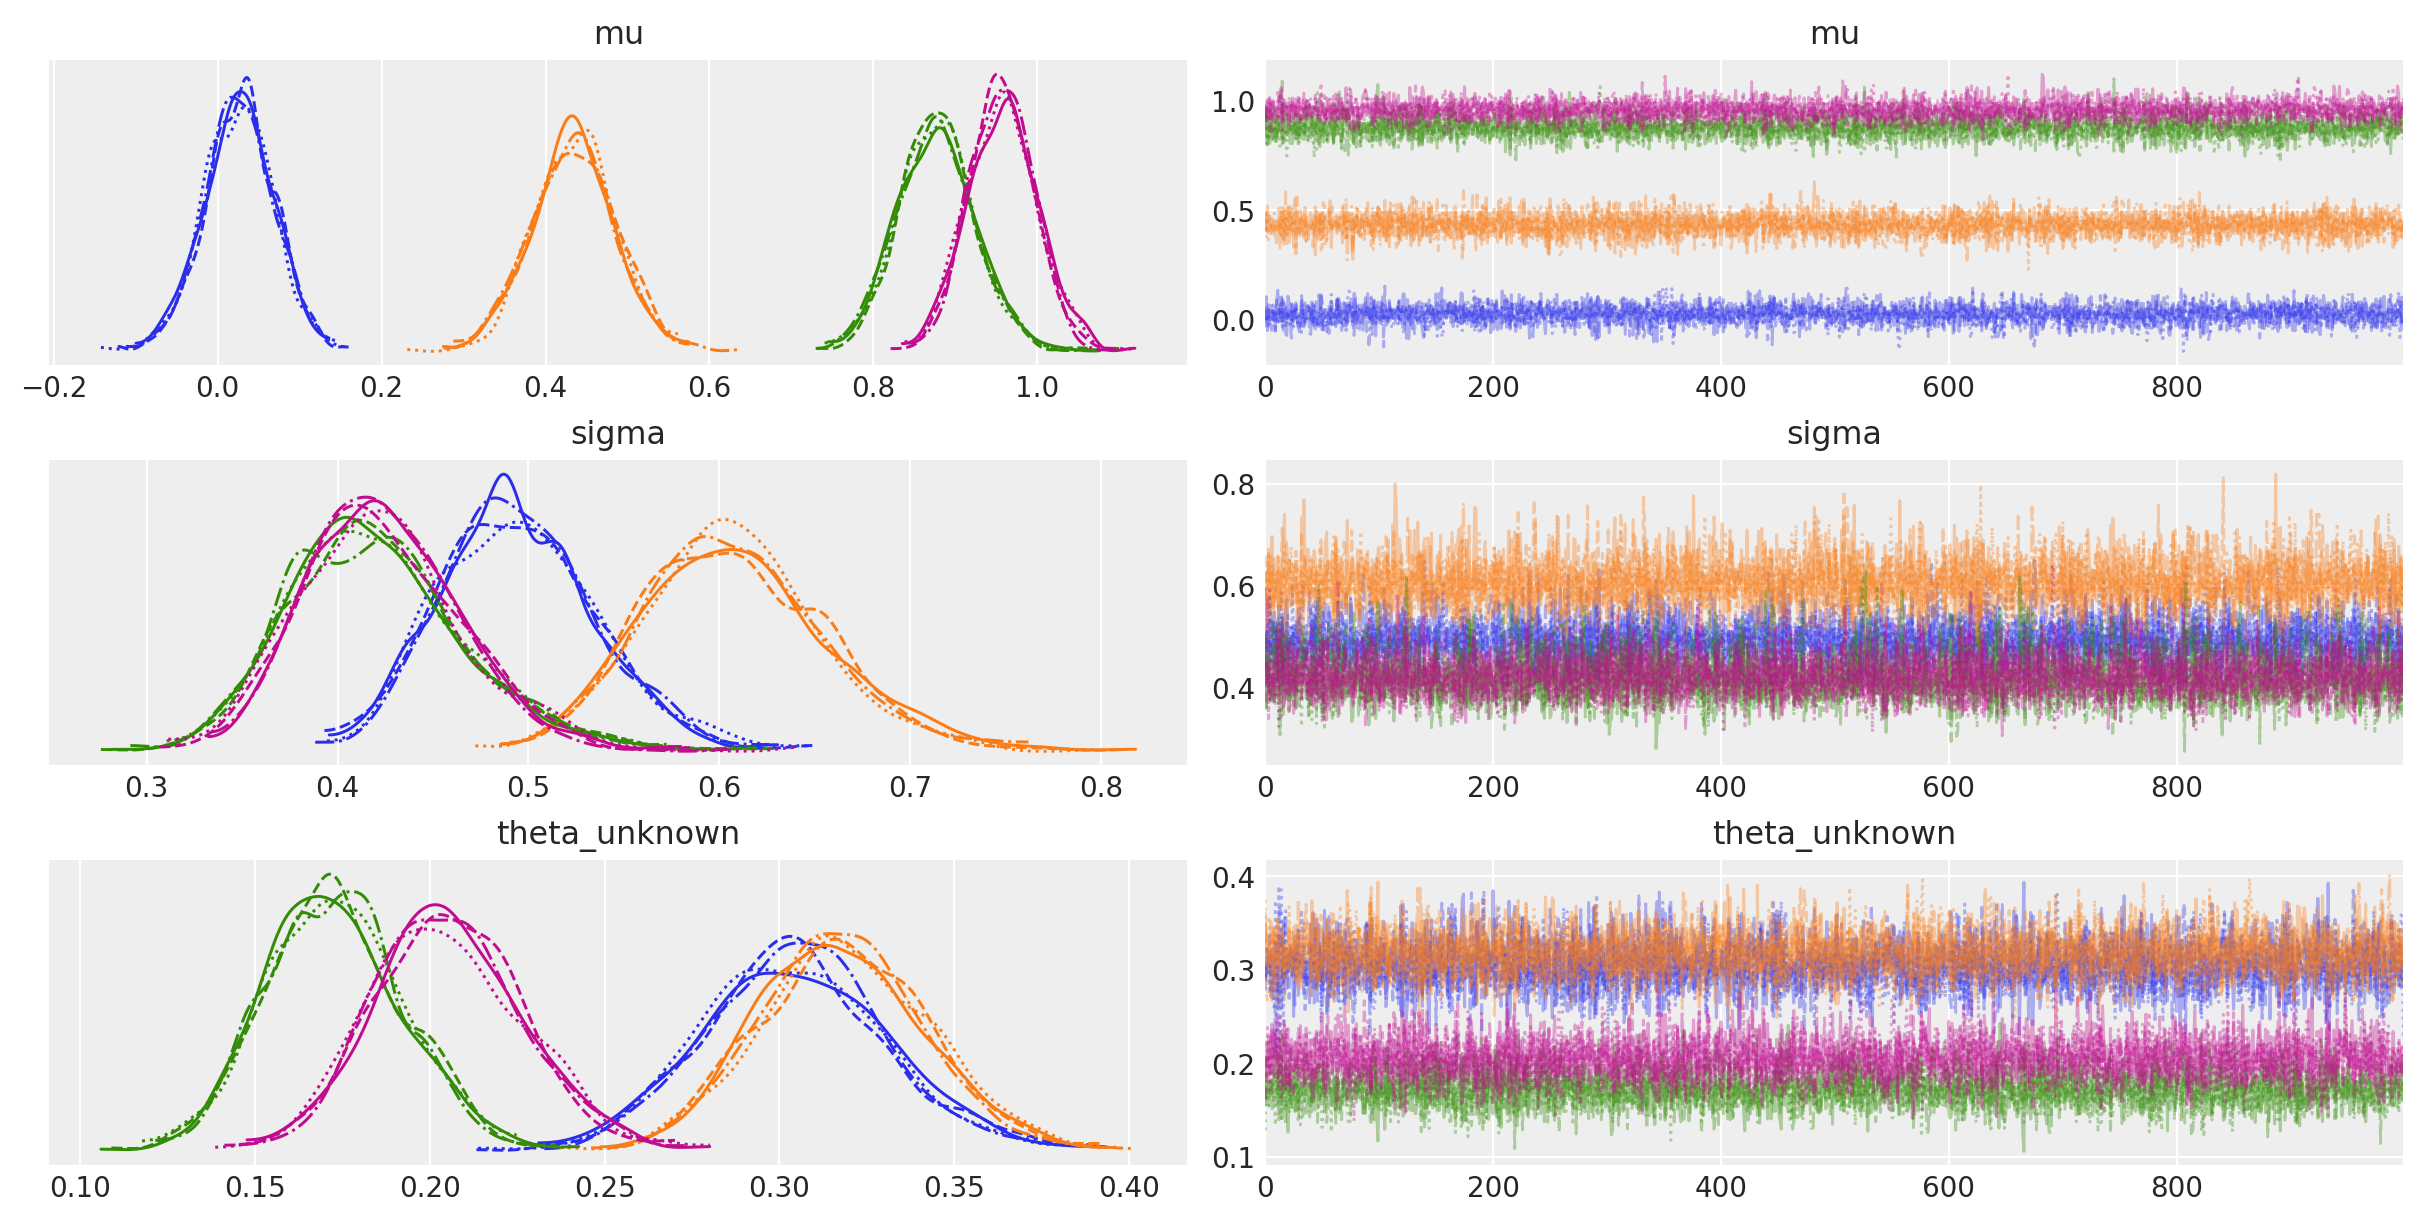

In [19]:
az.plot_trace(idata, var_names=["mu", "sigma", "theta_unknown"]);

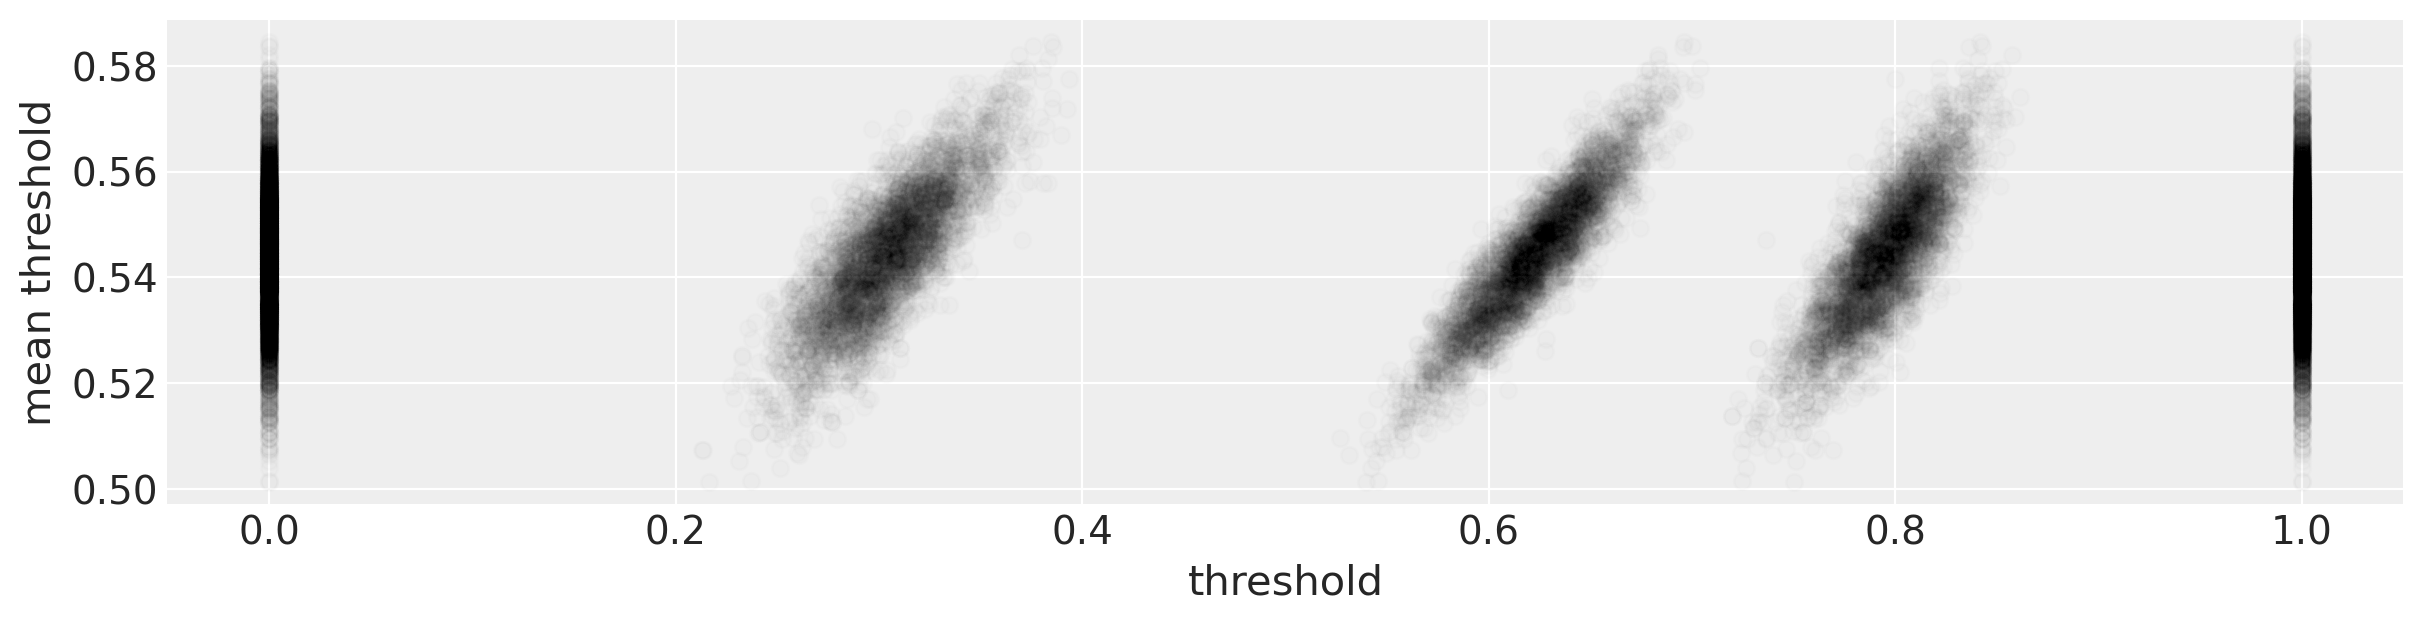

In [20]:
plot_cutpoints(idata)

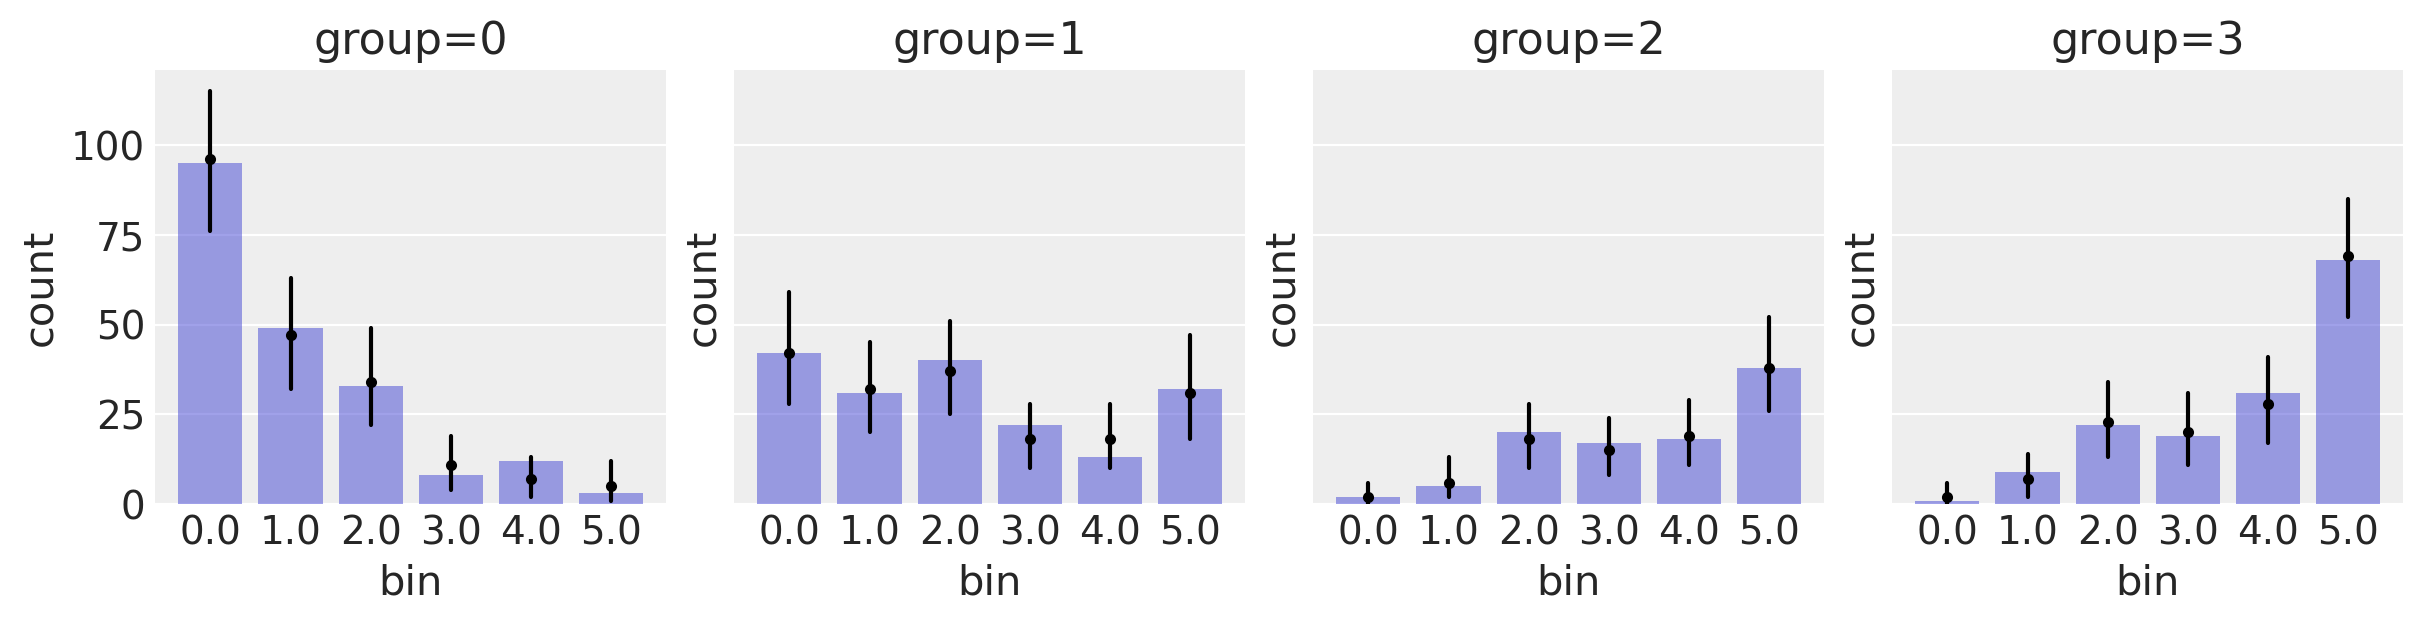

In [21]:
plot_posterior_predictive_groups(idata, grp_idx, K)

## Continuous predictor variables

## Combined continuous and categorical variables

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in February 2022

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl

Last updated: Sat Feb 19 2022

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 7.31.0

aesara: 2.3.8
aeppl : 0.0.18

matplotlib: 3.4.3
seaborn   : 0.11.0
arviz     : 0.11.4
numpy     : 1.21.5
pandas    : 1.4.0
pymc      : 4.0.0b2
aesara    : 2.3.8

Watermark: 2.3.0



:::{include} ../page_footer.md :::